## Introduction to the Project
This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Read on or watch the video below to explore more details. Once you’re ready to start competing, click on the "Join Competition button to create an account and gain access to the competition data. Then check out Alexis Cook’s Titanic Tutorial that walks you through step by step how to make your first submission!

### The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### What Data Will I Use in This Competition?
In this competition, you’ll gain access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled `train.csv` and the other is titled `test.csv`.

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.

Check out the “Data” tab to explore the datasets even further. Once you feel you’ve created a competitive model, submit it to Kaggle to see where your model stands on our leaderboard against other Kagglers.


### Refrences You Might Wanna Have a Look at
Source: [Kaggle](https://www.kaggle.com/competitions/titanic)


Planning Notebook: [Planning.ipynb](https://github.com/muhammadanas0716/Machine-Learning-Projects-101/blob/main/Titanic%20-%20Machine%20Learning%20from%20Disaster/Planning....ipynb)

In [1]:
# Importing all the needed libraries

# Remove Warnings
import warnings
warnings.filterwarnings("ignore")

# Data Analysis and EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


# PreProcessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Some Extras
import xgboost as xgb

# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

Done Importing!

## Exploratory Data Analysis (EDA)
0. Most Correlated values
1. Value counts of the numeric columns
2. Frequencies Plotting (PLOTTING OF ABOVE POINT)
3. This FEATURE VS this FEATURE
4. Any Null values

### TODOS
* Removing the pre-built index column (PANDAS)
* Creating a **Family** column, by adding the **SibSp** and **Parch**
* Cnverting the **Fare** column to an integer or round the price to `1 decimal place`

In [2]:
# Loading the data
titanic_df = pd.read_csv("train.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


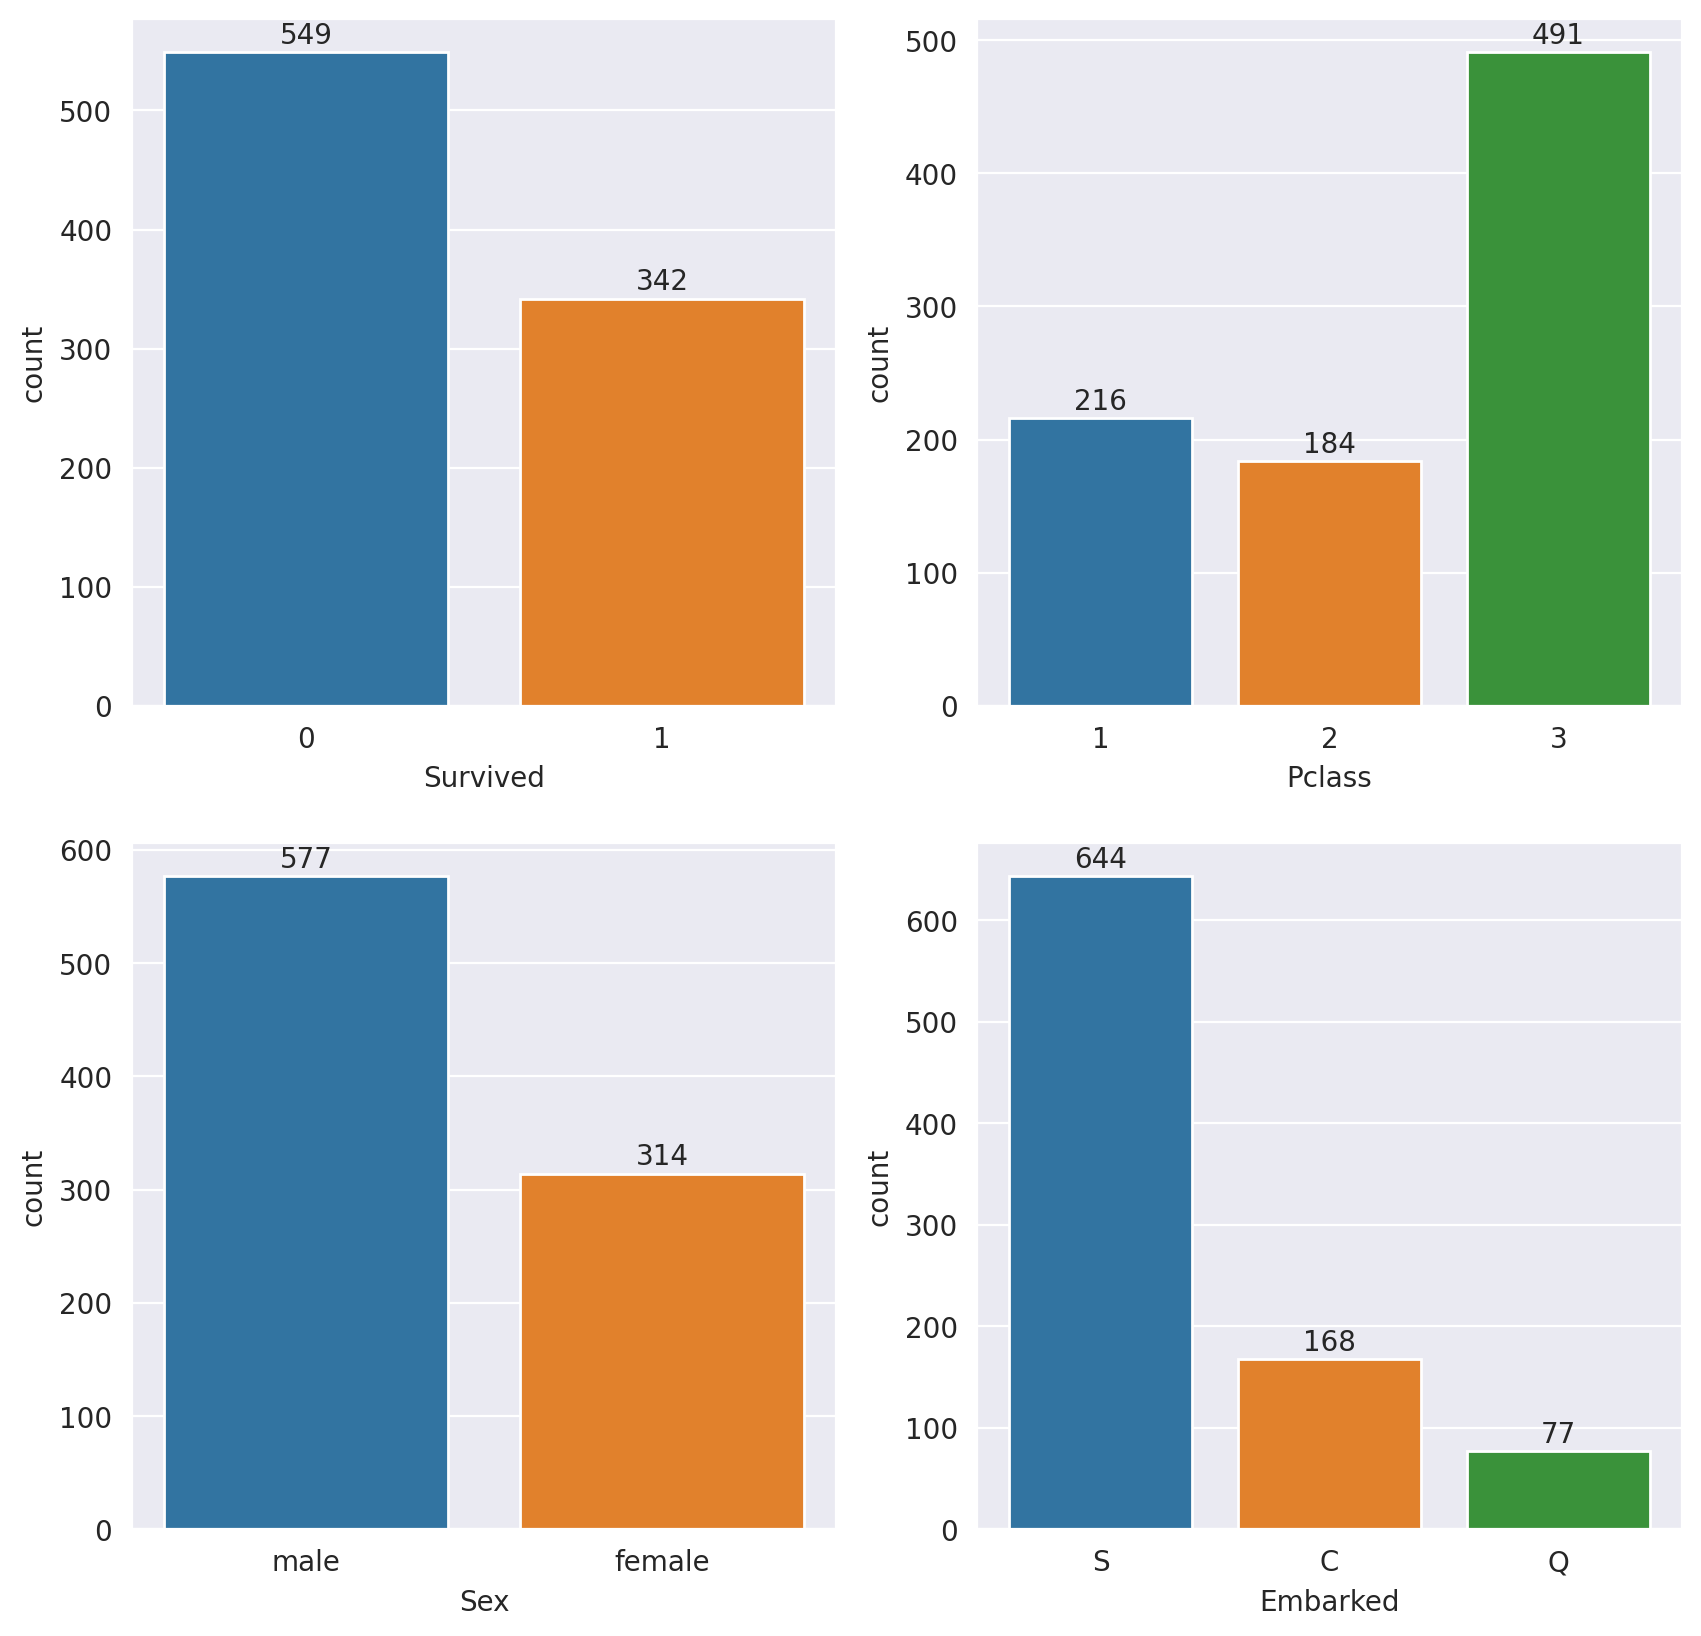

In [3]:
# Get the count of the needed columns
fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=200)
sns.countplot(data=titanic_df, x="Survived", ax=axes[0,0])
sns.countplot(data=titanic_df, x="Pclass", ax=axes[0, 1])
sns.countplot(data=titanic_df, x="Sex", ax=axes[1, 0])
sns.countplot(data=titanic_df, x="Embarked", ax=axes[1, 1])

for ax in axes.flat:
    ax.bar_label(ax.containers[0],label_type='edge', padding=1)
    ax.margins(x=0.05)
plt.show()

The above 4 plots show the count of some of the categories/features/columns I was interested in knowing about.

We can observe:
* In the first plot, most poeple seem to have died 😞
* In the second plot, majority of the population was in **Pclass** of 3 (i.e lower class)
* In the third plot, we can observe that most of the poeple on board were males (i.e 577)
* In the fourth plot, it's clear that most poeple embarked from Southampton and least from Queenstown

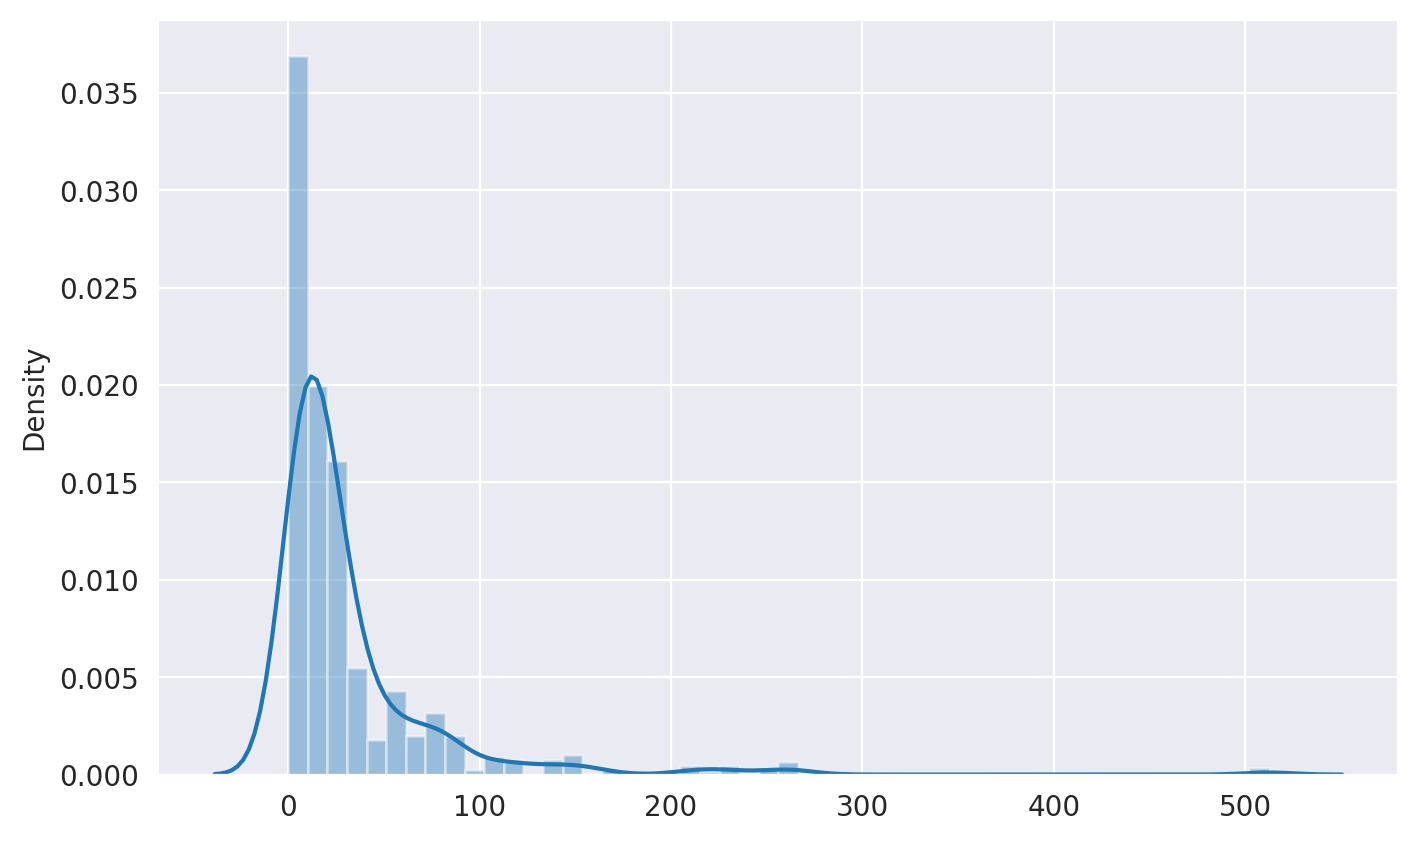

In [18]:
# Distribution of the Fares
plt.figure(figsize=(8, 5), dpi=200)
sns.distplot(x=titanic_df["Fare"])
plt.show()

Well, most of the prices are between 10-80.

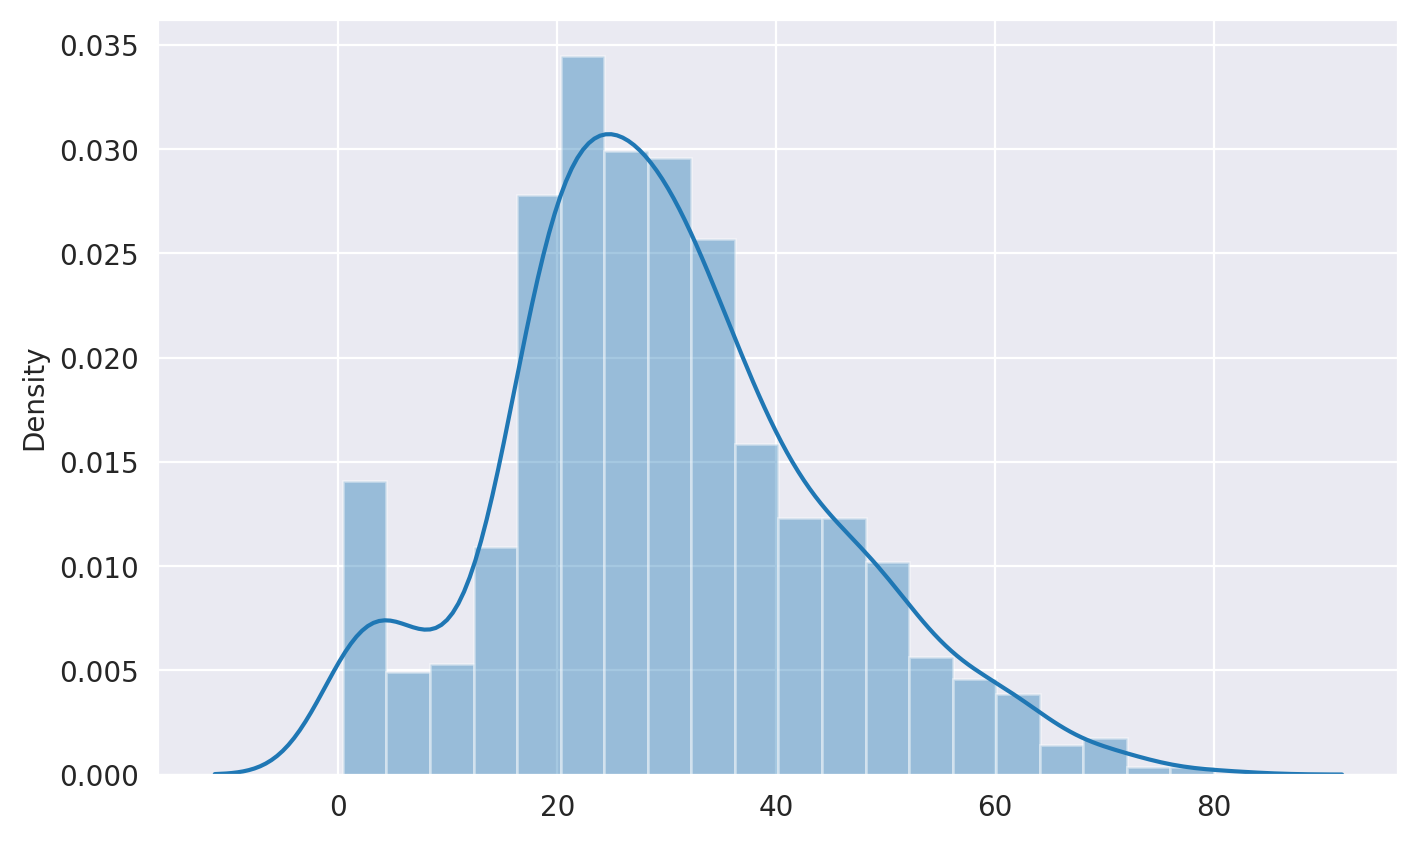

In [4]:
# Distribution of age
plt.figure(figsize=(8, 5), dpi=200)
sns.distplot(x=titanic_df["Age"])
plt.show()

Most poeple on board, seem to be young adults, between the age of 20-40. It could be just me but from what the histogram shows us, there seem to be a decent number of children as well!

Now let's clean the data a bit and then we'll move to relational plots.

In [5]:
# Shape of the dataset
print(f"""Columns: {titanic_df.shape[1]}
Rows: {titanic_df.shape[0]}""")

Columns: 12
Rows: 891


In [6]:
# Null Values
titanic_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Umm....well I don't think Cabin is very useful here. As more than 90% values are missing. Regarding age, we'll just fill it with the **mean**. And the 2 values regarding Embarked, we can just fill in **S** as this is the majority of the embarkments.

In [7]:
# Removing Cabin Column
titanic_df.drop("Cabin", axis=1, inplace=True)

# Filling the age column with the mean age
titanic_df["Age"].fillna(titanic_df["Age"].mean(), inplace=True)

# Filling in the Embarked column with S (i.e Southampton) as majority value is Southampton
titanic_df["Embarked"].fillna("S", inplace=True)

Column **SibSp** and **Parch** can be combined into a `FamilyMembers` Column..

In [8]:
titanic_df["FamilyMembers"] = titanic_df["SibSp"] + titanic_df["Parch"]

# Dropping the SibSp and Parch columns
titanic_df.drop(["SibSp", "Parch"], axis=1, inplace=True)

In [9]:
titanic_df["FamilyMembers"].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamilyMembers, dtype: int64

Oh, there are 10 numbers, let's try and reduce these 10 values to 4.

In [10]:
titanic_df['FamilyMembers'] = pd.cut(titanic_df['FamilyMembers'],
                                     bins=[0,1,4,7,100], 
                                     labels=['Alone','Small','Medium','Large'],
                                     right=False)
titanic_df["FamilyMembers"].value_counts()

Alone     537
Small     292
Medium     49
Large      13
Name: FamilyMembers, dtype: int64

Much more like it soo.....


Okay, we've done pretty well, let's move to some relational plots.

1. Sex VS. Survived
2. Pclass VS. Survived
3. FamilyMembers VS. Survived
4. Embarkment VS. Survived

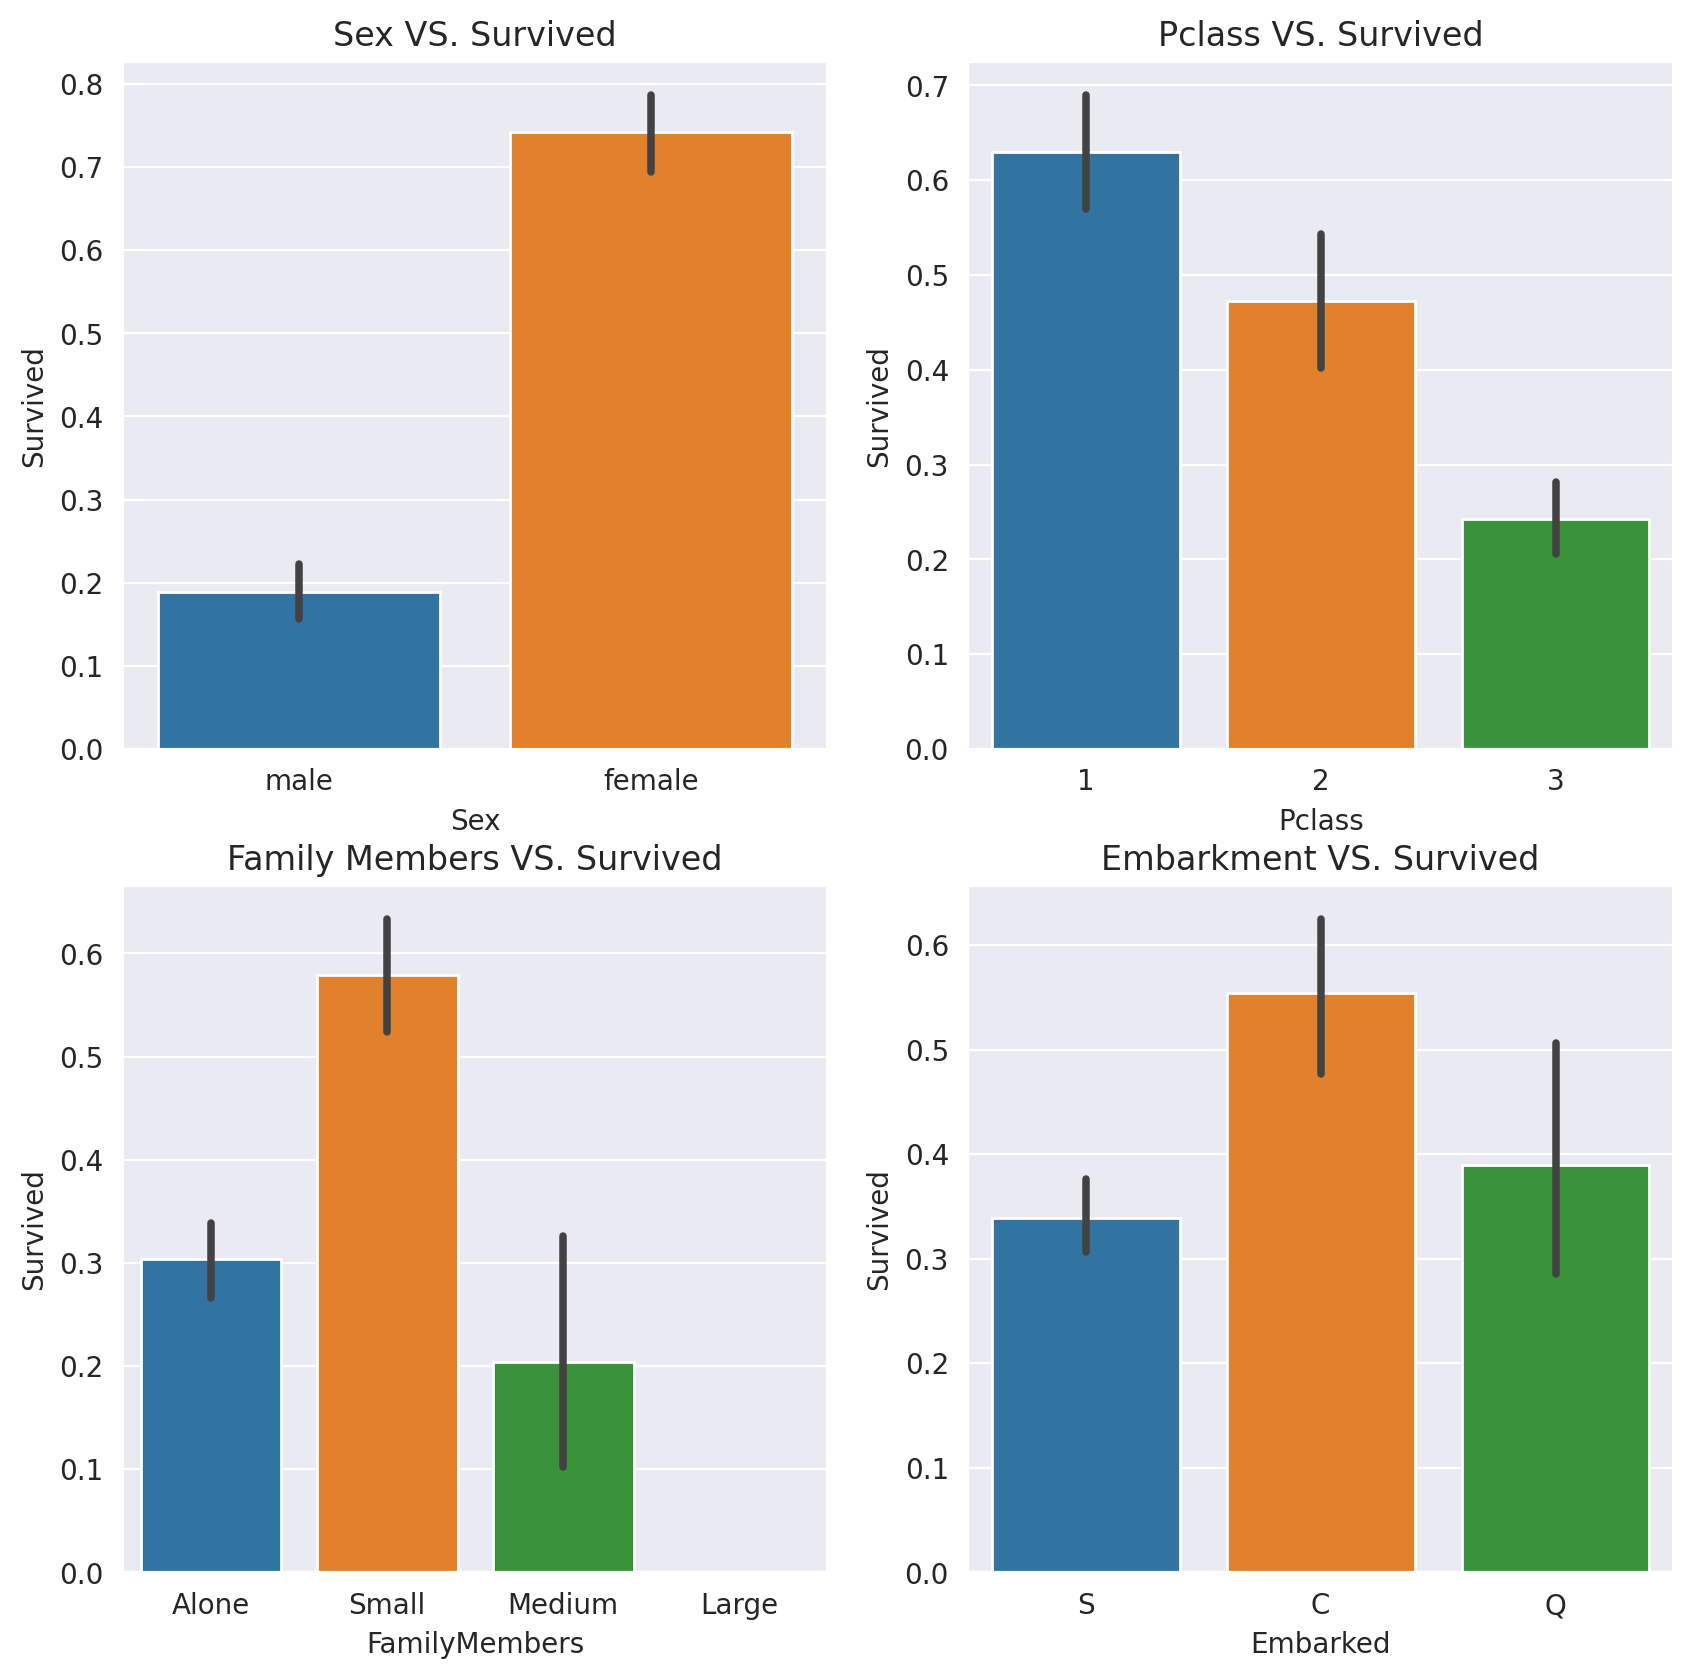

In [11]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=200)

# Plot on 1st subplot
sns.barplot(data=titanic_df, x="Sex", y="Survived", ax=axes[0, 0]).set(title="Sex VS. Survived")
sns.barplot(data=titanic_df, x="Pclass", y="Survived", ax=axes[0, 1]).set(title="Pclass VS. Survived")
sns.barplot(data=titanic_df, x="FamilyMembers", y="Survived", ax=axes[1, 0]).set(title="Family Members VS. Survived")
sns.barplot(data=titanic_df, x="Embarked", y="Survived", ax=axes[1, 1]).set(title="Embarkment VS. Survived")


# Show
plt.show()

Okay, now I still have to do some more relational plots, and for that, I'll need to convert the the string datatypes to numbers. This part is also crucial, as it's not ideal to pass strings to a ML model.

So yeah...

In [14]:
titanic_df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,FamilyMembers
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.25,S,Small
